<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Regresión local en $\mathcal{Rp}$

Se implementa el método de regresión (lineal) local con suavización con kernel en multiples dimensiones $p$ en cada punto de una variable dependiente.

La implementación fue realizada basada en las consideraciones del libro [The Elements of Statistical Learning](https://link.springer.com/book/10.1007/978-0-387-84858-7) secciones; 6.1 One-Dimensional Kernel Smoothers; 6.1.1 Local Linear Regression; y 6.3 Local Regression in IRp.

## Un ejemplo sencillo de regresión local en $\mathcal{Rp}$  con pocos datos
Los datos usados en esta sección están disponibles en [minitest.csv](https://drive.google.com/file/d/10Shxgajmm_loJf_3PrD6rQBF6-UqEOH3/view?usp=sharing)

In [ ]:
df  = pd.read_csv('minitest.csv')
X   = pd.DataFrame(df[['X1','X2','X3']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

Iniciamos calcuando los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$.

Damos mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas. 
Calcularemos los pesos de los puntos utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [ ]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [ ]:
def local_regression(X,W,Xo):
    # W     --> Matriz diagonal de pesos
    # X     --> Regresores
    # xo    --> punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`.

In [ ]:
k = 5 # Tamanio del vecindario #17 #25 #50

Y_local = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = get_weight_exp(xo, X, k)
    #W = get_weight_NN(xo, X, k)
    Ygorro = local_regression(X, W, xo)
    Y_local.append(Ygorro.item(0))

En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa los pesos `W` son la matriz identidad.

In [ ]:
Y_pred = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = np.mat(np.eye(X.shape[0])) 
    Ygorro = local_regression(X, W, xo)
    Y_pred.append(Ygorro.item(0))

No handles with labels found to put in legend.


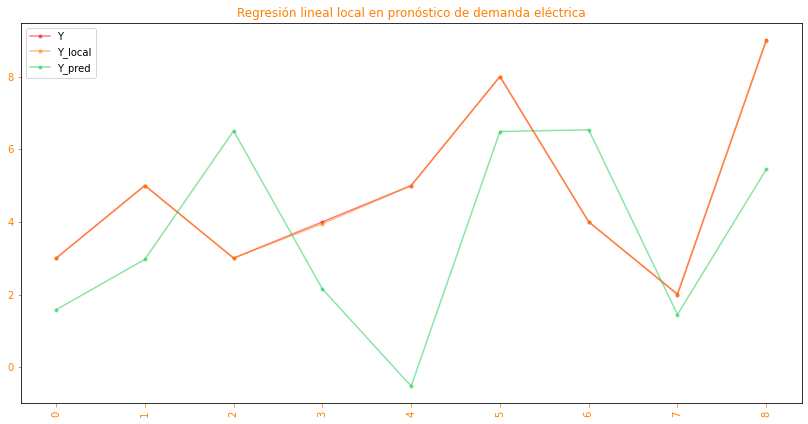

In [ ]:
fig  = plt.figure(figsize=(14,7))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(   colors=LETRASNARA, which='both')

axes.plot  ( Y      , '.-'  , color = 'red'        , label = 'Y'        ,alpha=1/2)
axes.plot  ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
axes.plot  ( Y_pred , '.-'  , color = VERDE        , label = 'Y_pred'   ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VEDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#AUX = np.arange( len(Y) )
#plt.scatter( AUX,    Y,     s=25 ,  marker='o' , color = 'red'   , label = 'X'        ,alpha=1)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7400, 9800])
#plt.axis([150, 300, 7400, 9800])
plt.legend()  
plt.xticks(rotation=90)
#plt.savefig('pronodemanda_t6_x.png', transparent=True)
plt.show()

## Regresión local en $\mathcal{Rp}$ en predicción de demanda eléctrica

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$. En esta sección, aplicaremos técnicas de regresión local con multiples regresores X.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [ ]:
df    = pd.read_csv('demanda.csv')

#df.std(numeric_only = True) 
#df.mean(numeric_only = True)
#df = df - df.mean(numeric_only = True)
#df = df / df.std(numeric_only = True)
X   = pd.DataFrame(df[['X1','X2']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()
#X = X + uniform()
X.tofile('X.csv',sep=',')
Y.tofile('Y.csv',sep=',')

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [ ]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,19].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,19].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Estandarizamos los datos de los regresores `X_train` y `X_test` restando la media y dividiendo entre la varianza.

In [ ]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
#X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [ ]:
dft1.std(numeric_only = True) 
dft1.mean(numeric_only = True)
dft1 = dft1 - dft1.mean(numeric_only = True)
dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
#X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`. 

In [ ]:
k = 0 # Tamanio del vecindario
kmin = 10
kmax = 19
Y_local_list= []
Y_local = []
aux = 0

for i in range(X.shape[0]):
    k = kmin
    flag = True
    while(flag==True):
        try:
            xo = X[[i]]
            W = get_weight_exp(xo, X, k)
            pred = local_regression(X, W, xo)
            Y_local.append(pred.item(0))
            aux = pred.item(0)
        except:
            print("Sorry! Singular matrix found in position i=",str(i),"k=", k)
            k = k + 1
            if(k>kmax):                
                flag = False
                Y_local.append(0)
        else:
            flag = False 
            
Y_local_list.append(Y_local)

Sorry! Singular matrix found in position i= 42 k= 10
Sorry! Singular matrix found in position i= 93 k= 10
Sorry! Singular matrix found in position i= 93 k= 11
Sorry! Singular matrix found in position i= 245 k= 10
Sorry! Singular matrix found in position i= 335 k= 10
Sorry! Singular matrix found in position i= 335 k= 11
Sorry! Singular matrix found in position i= 335 k= 12
Sorry! Singular matrix found in position i= 335 k= 13
Sorry! Singular matrix found in position i= 335 k= 14
Sorry! Singular matrix found in position i= 335 k= 15
Sorry! Singular matrix found in position i= 335 k= 16


In [ ]:
k = 0 # Tamanio del vecindario
klist = [25,35,50,100]
aux=0
for item in klist:
    k = item
    Y_local = []
    for i in range(X.shape[0]):
        try:
            xo = X[[i]]
            W = get_weight_exp(xo, X, k)
            Ygorro = local_regression(X, W, xo)
            Y_local.append(Ygorro.item(0))
            aux = Ygorro.item(0)
        except:
            Y_local.append(aux)
            print("Sorry! Singular matrix found in position i=",str(i))
    Y_local_list.append(Y_local)

En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa en este caso los pesos `W` son la matriz identidad.

In [ ]:
Y_pred = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = np.mat(np.eye(X.shape[0])) 
    Ygorro = local_regression(X, W, xo)
    Y_pred.append(Ygorro.item(0))

Calculamos los errores de los métodos de regresión comparados, variando además los tamaños de las vecindades `k`.

In [ ]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [ ]:
mae_pred  = trunc(mean_absolute_error(Y,Y_pred),4)
mae_local_k0 = trunc(mean_absolute_error(Y,Y_local_list[0]),4)
mae_local_k1 = trunc(mean_absolute_error(Y,Y_local_list[1]),4)
mae_local_k2 = trunc(mean_absolute_error(Y,Y_local_list[2]),4)
mae_local_k3 = trunc(mean_absolute_error(Y,Y_local_list[3]),4)
mae_local_k4 = trunc(mean_absolute_error(Y,Y_local_list[4]),4)

In [ ]:
mse_pred  = trunc(mean_squared_error(Y,Y_pred),4)
mse_local_k0 = trunc(mean_squared_error(Y,Y_local_list[0]),4)
mse_local_k1 = trunc(mean_squared_error(Y,Y_local_list[1]),4)
mse_local_k2 = trunc(mean_squared_error(Y,Y_local_list[2]),4)
mse_local_k3 = trunc(mean_squared_error(Y,Y_local_list[3]),4)
mse_local_k4 = trunc(mean_squared_error(Y,Y_local_list[4]),4)

In [ ]:
mape_pred  = trunc(mean_absolute_percentage_error(Y,Y_pred),4)
mape_local_k0 = trunc(mean_absolute_percentage_error(Y,Y_local_list[0]),4)
mape_local_k1 = trunc(mean_absolute_percentage_error(Y,Y_local_list[1]),4)
mape_local_k2 = trunc(mean_absolute_percentage_error(Y,Y_local_list[2]),4)
mape_local_k3 = trunc(mean_absolute_percentage_error(Y,Y_local_list[3]),4)
mape_local_k4 = trunc(mean_absolute_percentage_error(Y,Y_local_list[4]),4)

print('| REGRESIÓN      | MAE            | MSD            | MAPE         |')
print('| :------------- | -------------: | -------------: |-------------:|')
print('| local, k=10 |',str(mae_local_k0),'   |',str(mse_local_k0),'   |   ',str(mape_local_k0),'|')
print('| local, k=25 |',str(mae_local_k1),'   |',str(mse_local_k1),'   |   ',str(mape_local_k1),'|')
print('| local, k=35 |',str(mae_local_k2),'   |',str(mse_local_k2),'   |   ',str(mape_local_k2),'|')
print('| local, k=50 |',str(mae_local_k3),'   |',str(mse_local_k3),'   |   ',str(mape_local_k3),'|')
print('| local, k=100|',str(mae_local_k4),'   |',str(mse_local_k4),'   |   ',str(mape_local_k4),'|')
print('|    lineal      |',str(mae_pred),'    |',str(mse_pred),'   |   ',str(mape_pred),'|')

| REGRESIÓN      | MAE            | MSD            | MAPE         |
| :------------- | -------------: | -------------: |-------------:|
| local, k=10 | 77.4973    | 323440.045    |    0.009 |
| local, k=25 | 83.5068    | 14118.722    |    0.0096 |
| local, k=35 | 98.6564    | 18483.2236    |    0.0113 |
| local, k=50 | 109.6632    | 21942.6356    |    0.0126 |
| local, k=100| 123.9285    | 26331.6078    |    0.0142 |
|    lineal      | 138.5861     | 32615.1951    |    0.0159 |


Graficamos los resultados de predicción de la regresión local con k= [10,25,35,50] y regresión local para pronosticar los datos de prueba `Y`.

No handles with labels found to put in legend.


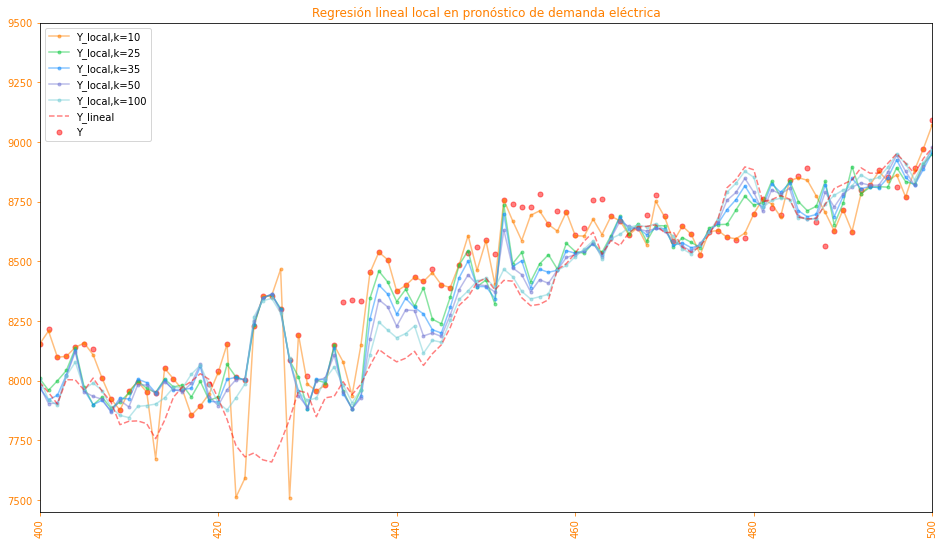

In [ ]:
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(Y) )
plt.scatter( AUX,Y,s=25,marker='o' , color = 'red'      , label = 'Y'              ,alpha=1/2)
axes.plot  ( Y_local_list[0], '.-' , color = LETRASNARA , label = 'Y_local,k=10'   ,alpha=1/2)
axes.plot  ( Y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
axes.plot  ( Y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
axes.plot  ( Y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
axes.plot  ( Y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
axes.plot  ( Y_pred         , '--' , color = 'red'      , label = 'Y_lineal'       ,alpha=1/2)
#axes.plot ( Y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

plt.axis([0,  600, 7650, 9800])
plt.axis([100,  200, 7650, 9500])
plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_3.png', transparent=True)
plt.show()

## Algunas ligas útiles que se utilizaron se pueden encontrar aquí
* [Locally weighted linear Regression using Python](https://www.geeksforgeeks.org/locally-weighted-linear-regression-using-python/)*   
* [Kernel regression estimation](https://bookdown.org/egarpor/NP-UC3M/kre-i-kre.html)
* [Kernel Density Estimation and Non-Parametric Regression](https://towardsdatascience.com/kernel-density-estimation-and-non-parametric-regression-ecebebc75277) 
* [Libreria localreg](https://github.com/sigvaldm/localreg) 
* [tips-locally-weighted-linear-regression](https://www.kaggle.com/alincijov/tips-locally-weighted-linear-regression)

* [LOESS Smoothing data using local regression](https://towardsdatascience.com/loess-373d43b03564)
*  [LOWESS Smoother, STATSMODELS](https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html)
*   https://www.allendowney.com/blog/2019/04/01/local-regression-in-python/
*   https://www.geeksforgeeks.org/implementation-of-locally-weighted-linear-regression/
*   https://towardsdatascience.com/locally-weighted-linear-regression-in-python-3d324108efbf

In [ ]:
R= np.asarray([2,4,5,6,7,8,5,6,3,2,4,7,3,4,2,4,6,8,5,3,45,6,8,9,6,4,6,8,3,4,3,1,2,5,9,8,4,7,6,5,3,2,5,7,3,5,3,2,4,5,2,6,7,5,5])
import numpy as np
rng = np.random.RandomState(42)
R = rng.random_sample((100, 3))
kdeGauss = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(R)
log_density = kdeGauss.score_samples(R[:3])

kdeEspane = KernelDensity(kernel='epanechnikov', bandwidth=0.05).fit(R)
